<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [6]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [7]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'

In [8]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [9]:
res_fluxes,res_inv_vars,res_masks,redshifts,SNs, ras, decs, category, sublabel = np.load(os.path.join(root_data,'SDSS_BOSS_preprocessed/%s.npy'%label), allow_pickle=True)

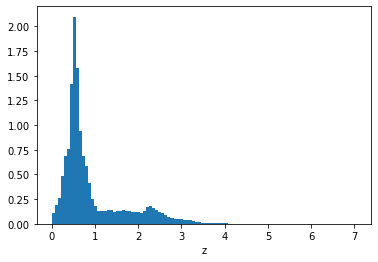

In [10]:
_ = plt.hist(redshifts,bins=100,density=True)
plt.xlabel('z')
plt.show()

In [11]:
res_fluxes_   = np.asarray(list(res_fluxes))
res_inv_vars_ = np.asarray(list(res_inv_vars))
res_masks_    = np.asarray(list(res_masks))

In [12]:
def redshift_bin(min_z, max_z, z_array, arrays):
    num  = len(arrays)
    indx = np.where((redshifts>min_z)*(redshifts<max_z))[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, ras, decs, category, sublabel = redshift_bin(min_z, max_z, redshifts, [res_fluxes_, res_masks_, res_inv_vars_, redshifts, ras, decs, category, sublabel])

new datasize:  84777


In [13]:
DATASET_SIZE = len(res_fluxes)

In [14]:
SNs =[]
for ii in range(DATASET_SIZE):
    SNs.append(np.sum(res_fluxes[ii][np.where(res_masks[ii])])//np.sqrt(np.sum(1./res_inv_vars[ii][np.where(res_masks[ii])])))
SNs= np.asarray(SNs)

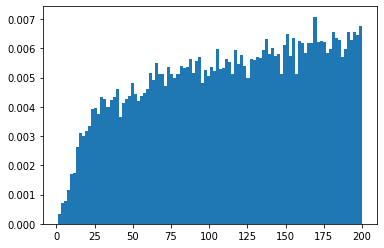

In [15]:
_ = plt.hist(SNs, density=True,bins=100,range=(1,200))

Text(0.5, 0, 'S/N')

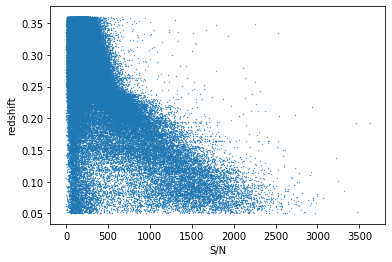

In [16]:
plt.scatter(SNs,redshifts, s=0.1)
plt.ylabel('redshift')
plt.xlabel('S/N')

In [17]:
def SN_bin(min_SN, SNs, arrays):
    num  = len(arrays)
    indx = np.where(SNs>min_SN)[0]
    arrays_new = [arrays[ii][indx] for ii in range(num)]
    print('new datasize: ', len(indx))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = SN_bin(min_SN, SNs, [res_fluxes, res_masks, res_inv_vars, redshifts,SNs,ras, decs, category, sublabel])

new datasize:  79998


In [18]:
boolean_mask = (res_masks==0)

In [19]:
mask_fracs = np.mean(boolean_mask,axis=1)

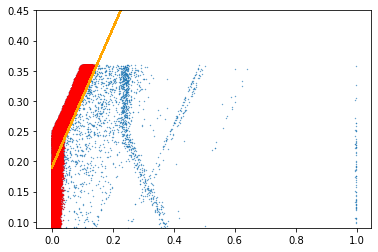

In [20]:
plt.scatter(mask_fracs, redshifts, s=0.1)
plt.plot(mask_fracs,mask_fracs*1.15+0.19, color='orange')
keep = redshifts>mask_fracs*1.15+0.19
keep_low = mask_fracs<0.04
keep = np.logical_or(keep,keep_low)
plt.scatter(mask_fracs[keep], redshifts[keep], color='red', s=0.1)
plt.ylim(0.09,0.45)
plt.show()

In [21]:
def mask_bin(keep, arrays):
    num  = len(arrays)
    arrays_new = [arrays[ii][keep] for ii in range(num)]
    print('new datasize: ', len(arrays_new[0]))
    return arrays_new

res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = mask_bin(keep, [res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel])

new datasize:  77873


In [22]:
boolean_mask = (res_masks==0)

In [23]:
mask_fracs = np.mean(boolean_mask,axis=1)
max(mask_fracs)

0.146

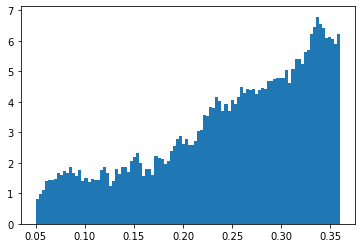

In [24]:
_ = plt.hist(redshifts, density=True, bins=100)

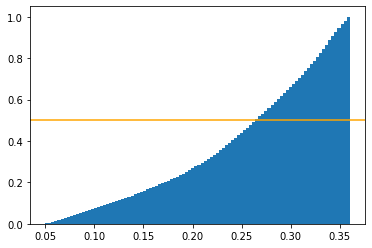

In [25]:
_ = plt.hist(redshifts, density=True, bins=100, cumulative=True)
plt.axhline(0.5,color='orange')

In [26]:
def calc_noise_floor(res_fluxes, res_masks, res_inv_vars):
    floors = []
    sanity = []
    MAXs   = []
    for ii in range(len(res_fluxes)):
        MAX = max(res_fluxes[ii][res_masks[ii]]*np.sqrt(res_inv_vars[ii][res_masks[ii]]))
        MAXs.append(MAX)
        N   = np.where(res_fluxes[ii][res_masks[ii]]*np.sqrt(res_inv_vars[ii][res_masks[ii]])==MAX)[0]
        if MAX>50.:
            print(N)
            floor2 = (res_fluxes[ii][res_masks[ii]][N]/50.)**2-1./res_inv_vars[ii][res_masks[ii]][N]
            sanity.append(res_fluxes[ii][res_masks[ii]][N]/np.sqrt(floor2+1./res_inv_vars[ii][res_masks[ii]][N]))
            floors.append(floor2)
        else:
            floors.append(0.)
    return floors, sanity, MAXs


noise_floors, sanity, MAXs = calc_noise_floor(res_fluxes, res_masks, res_inv_vars)

[783 786 787 800 808 809 868 941 942 990 991 992 993 994 995 996 997 998
 999]
[ 69 800 875 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937
 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955
 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973
 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991
 992 993 994 995 996 997 998 999]
[659 679 688 784 787 788 801 810 868 869 916 925 987 988 989 990 991 992
 993 994 995 996 997 998 999]
[925]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119

In [27]:
sanity = np.asarray(sanity)
noise_floors = np.asarray(noise_floors)
MAXs = np.asarray(MAXs)

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


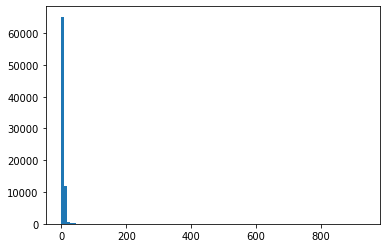

In [28]:
_ = plt.hist(MAXs, bins=100)

In [29]:
np.save(os.path.join(root_prepped,'prepped_data_spectra_%s.npy'%label_), [res_fluxes, res_masks, res_inv_vars])

np.save(os.path.join(root_prepped,'prepped_data_prop_%s.npy'%label_), [redshifts, SNs, ras, decs, category, sublabel])